In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, Flatten
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Load data
data = pd.read_csv('/content/drive/MyDrive/final_training_data.csv')

# Preprocess the timestamp column to extract relevant information
data['timestamp'] = pd.to_datetime(data['timestamp'])
data['Hour'] = data['timestamp'].dt.hour
data['DayOfWeek'] = data['timestamp'].dt.dayofweek
data['Month'] = data['timestamp'].dt.month

# Remove negative values for appropriate columns
for column in data.columns:
    if column != 'timestamp':
        data[column] = data[column].clip(lower=0)  # Clip negative values

# Define features and targets
X = data[['Hour', 'DayOfWeek', 'Month', 'Total']].values
y = data[['Washer', 'HVAC', 'Lights', 'Dryer', 'Recs', 'WaterHeater', 'Other']].values

Mounted at /content/drive


In [3]:
# Create sequences function
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps + 1):
        v = X[i:(i + time_steps)]
        Xs.append(v)
        ys.append(y[i + time_steps - 1])
    return np.array(Xs), np.array(ys)

TIME_STEPS = 10

# Create sequences
X_seq, y_seq = create_dataset(X, y, TIME_STEPS)

# Split data into training and testing
split_ratio = 0.8
split_index = int(len(X_seq) * split_ratio)

X_train, y_train = X_seq[:split_index], y_seq[:split_index]
X_test, y_test = X_seq[split_index:], y_seq[split_index:]

# Define CNN model creation function
def create_cnn_lstm_model(input_shape):
    model = Sequential()
    # Add convolutional layers
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    # Reshape the data for LSTM
    model.add(tf.keras.layers.Reshape((-1, 64)))  # 64 corresponds to the number of filters in the last Conv1D layer
    # Add LSTM layers
    model.add(LSTM(50, return_sequences=True))
    model.add(LSTM(50))
    # Add dense layers
    model.add(Dense(7, activation='linear'))  # Output layer with linear activation for regression
    model.compile(optimizer='adam', loss='mse')
    return model

# Create and compile the model
model = create_cnn_lstm_model((X_train.shape[1], X_train.shape[2]))
model.summary()

# Train model
model.fit(X_train, y_train, epochs=10, batch_size=16, validation_data=(X_test, y_test))

# Save model
model.save('/content/drive/MyDrive/final_model_category.h5')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 8, 32)             416       
                                                                 
 max_pooling1d (MaxPooling1  (None, 4, 32)             0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 2, 64)             6208      
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 1, 64)             0         
 g1D)                                                            
                                                                 
 reshape (Reshape)           (None, 1, 64)             0         
                                                                 
 lstm (LSTM)                 (None, 1, 50)             2

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


35/35 [==============================] - 0s 6ms/step


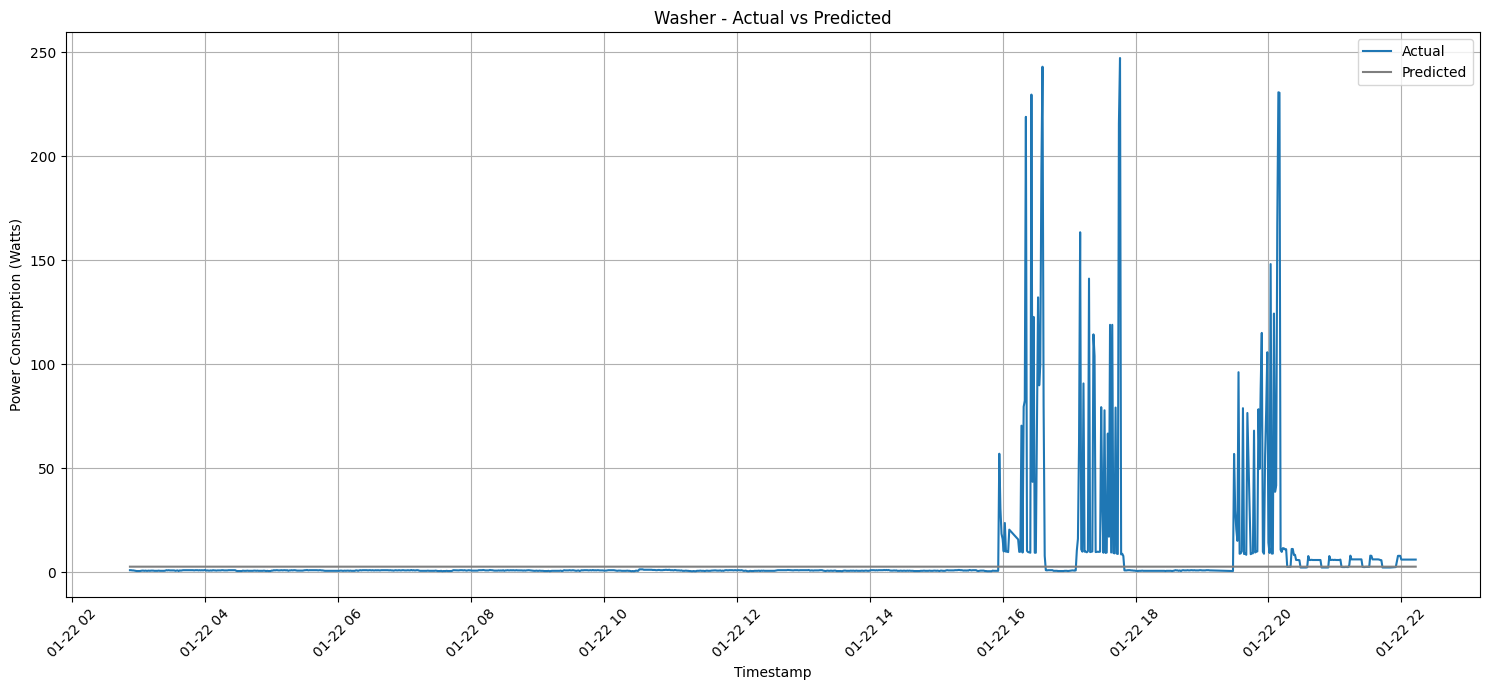

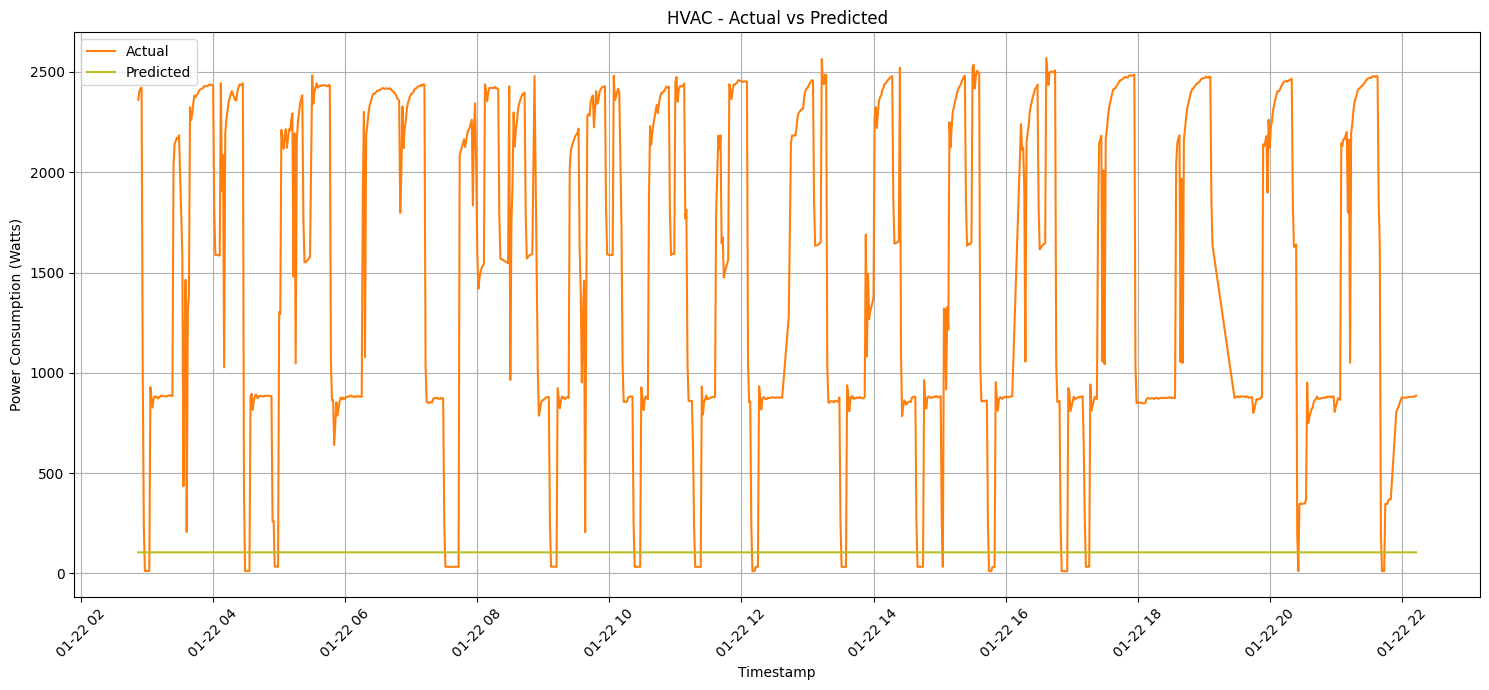

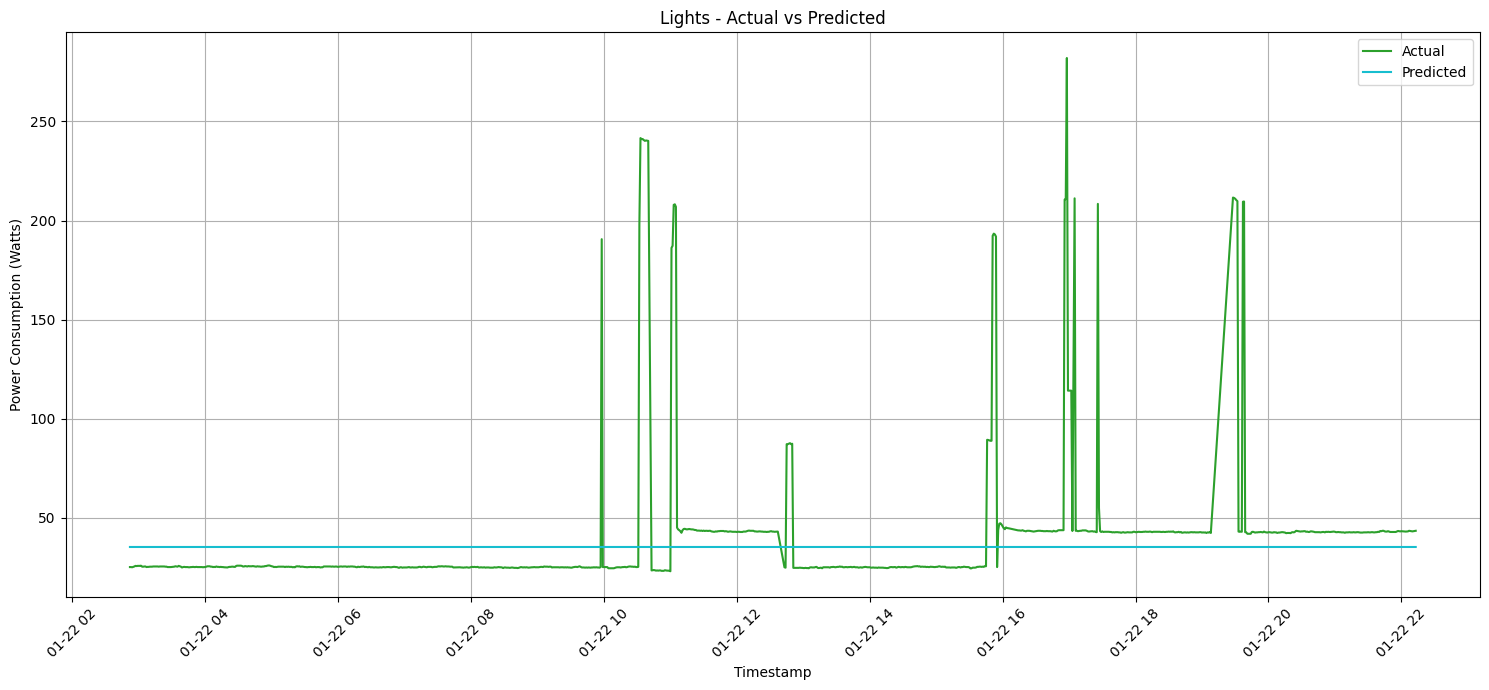

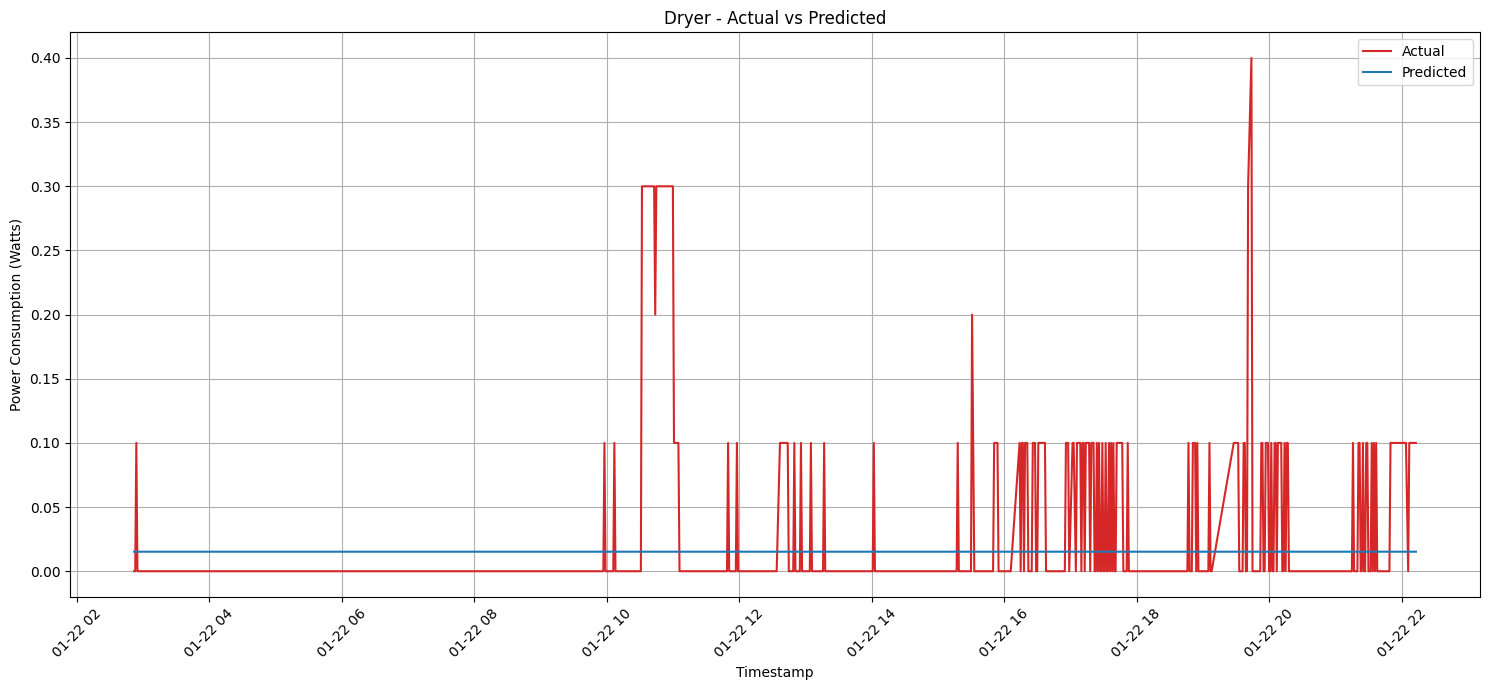

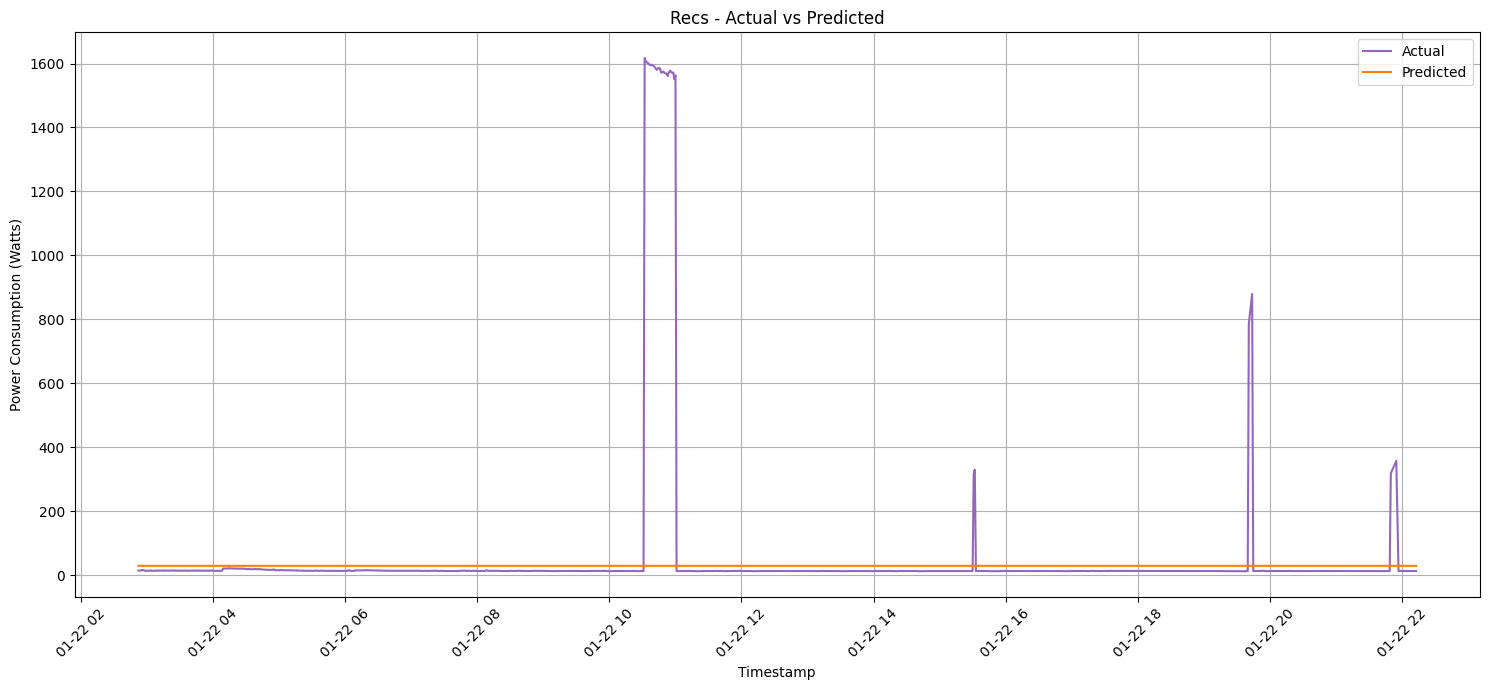

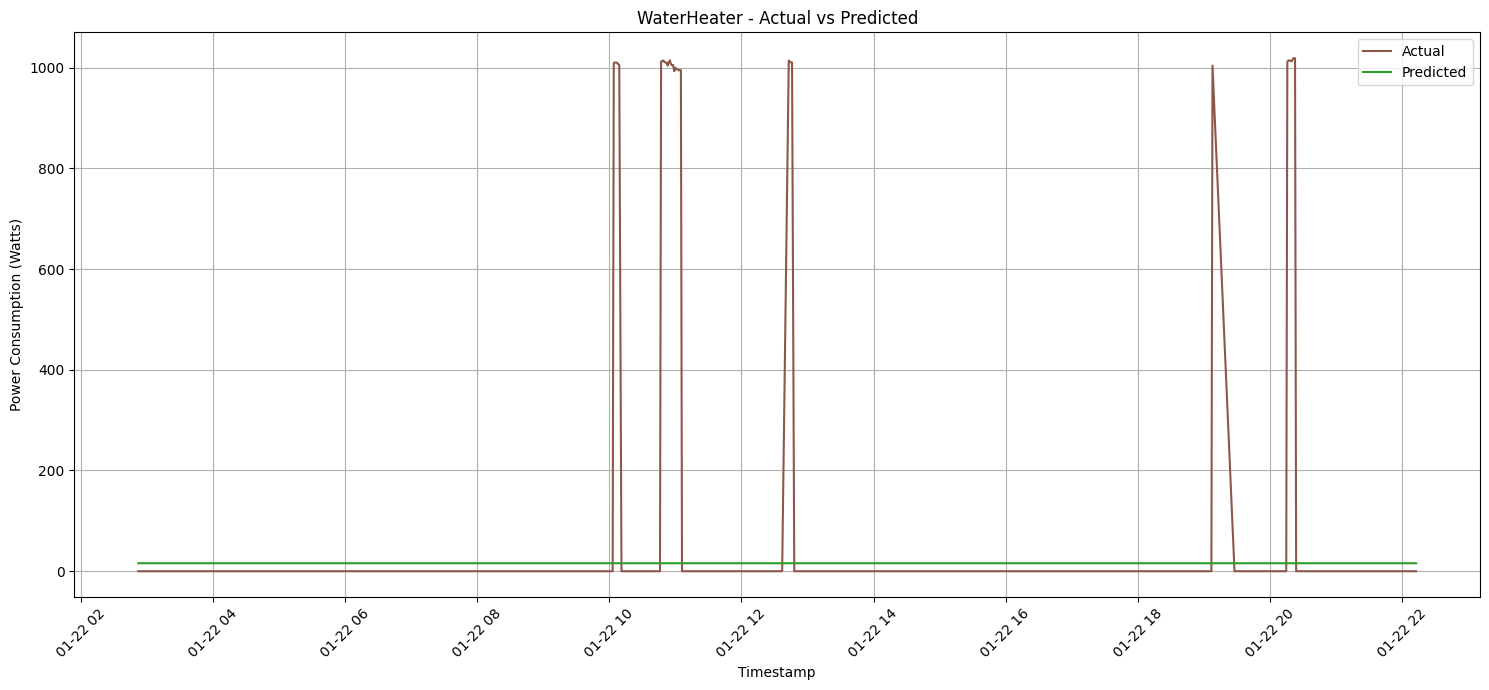

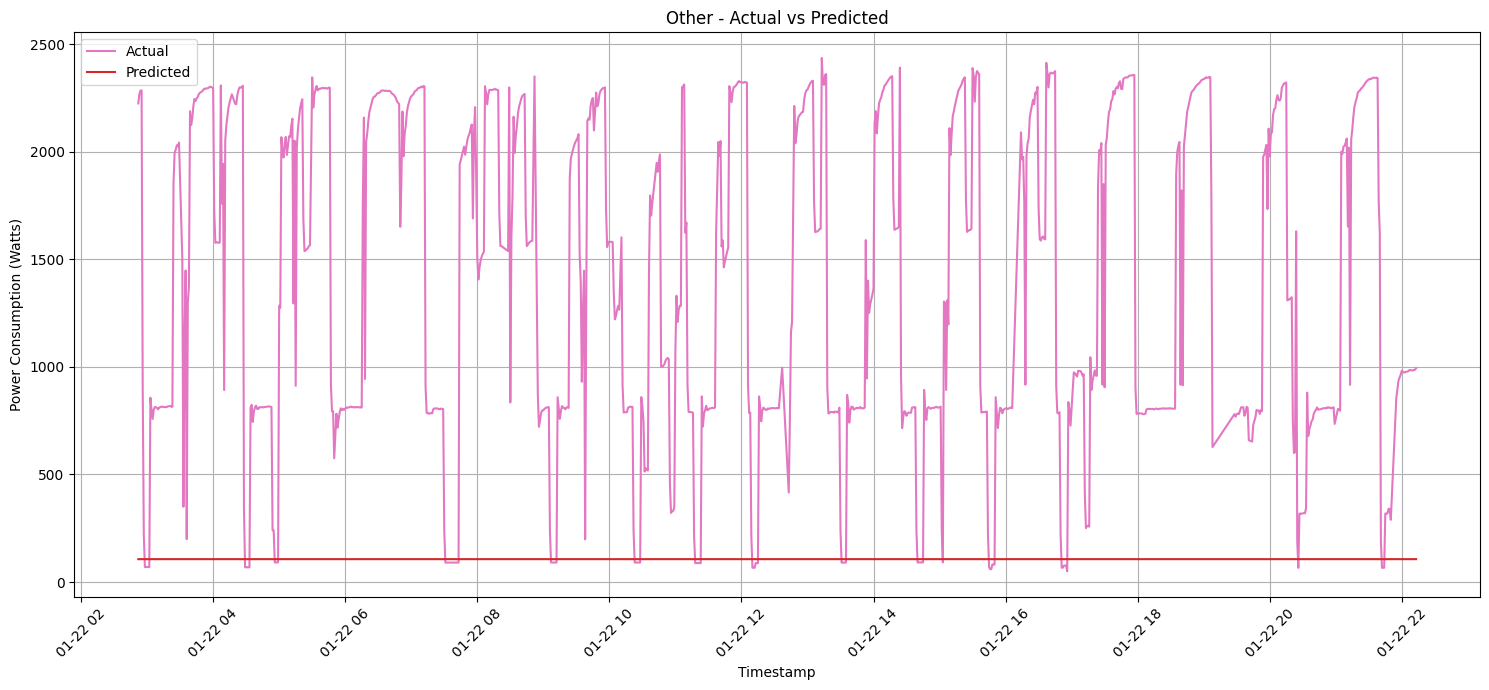

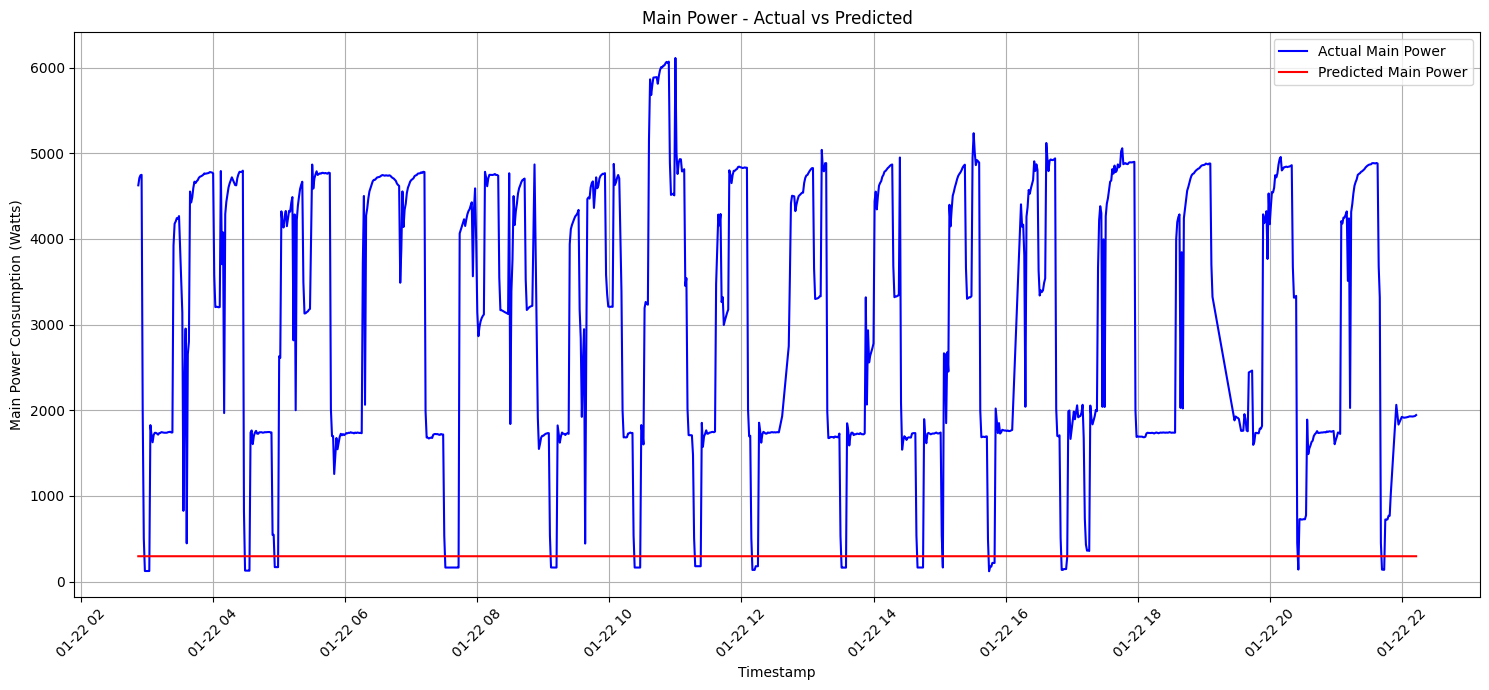

In [6]:
predicted_values = model.predict(X_test)

# Extract timestamps for test
test_timestamps = data['timestamp'].iloc[-len(X_test):]

appliance_names = ['Washer', 'HVAC', 'Lights', 'Dryer', 'Recs', 'WaterHeater', 'Other']

# Create an empty DataFrame to store the results
results_df = pd.DataFrame(columns=['Appliance', 'Actual Total (Watts)', 'Predicted Total (Watts)', 'Percentage Error'])

actual_values = y_test


for idx, appliance in enumerate(appliance_names):
    plt.figure(figsize=(15, 7))

    # Plot actual usage
    plt.plot(test_timestamps, actual_values[:, idx], label='Actual', color='C'+str(idx))

    # Plot predicted usage
    plt.plot(test_timestamps, predicted_values[:, idx], label='Predicted', color='C'+str(idx+7))

    plt.title(f"{appliance} - Actual vs Predicted")
    plt.xlabel('Timestamp')
    plt.ylabel('Power Consumption (Watts)')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Calculate actual and predicted total power in watts for the main power
actual_main_power = actual_values.sum(axis=1)
predicted_main_power = predicted_values.sum(axis=1)

# Plot actual vs predicted main power
plt.figure(figsize=(15, 7))
plt.plot(test_timestamps, actual_main_power, label='Actual Main Power', color='blue')
plt.plot(test_timestamps, predicted_main_power, label='Predicted Main Power', color='red')
plt.title("Main Power - Actual vs Predicted")
plt.xlabel('Timestamp')
plt.ylabel('Main Power Consumption (Watts)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()